In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt

from ccblade import CCAirfoil, CCBlade

/home/marucs/anaconda3/envs/thesis/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# geometry
Rhub = 1.5
Rtip = 63.0

r = np.array([2.8667, 5.6000, 8.3333, 11.7500, 15.8500, 19.9500, 24.0500,
              28.1500, 32.2500, 36.3500, 40.4500, 44.5500, 48.6500, 52.7500,
              56.1667, 58.9000, 61.6333])
chord = np.array([3.542, 3.854, 4.167, 4.557, 4.652, 4.458, 4.249, 4.007, 3.748,
                  3.502, 3.256, 3.010, 2.764, 2.518, 2.313, 2.086, 1.419])
theta = np.array([13.308, 13.308, 13.308, 13.308, 11.480, 10.162, 9.011, 7.795,
                  6.544, 5.361, 4.188, 3.125, 2.319, 1.526, 0.863, 0.370, 0.106])
B = 3  # number of blades

tilt = 5.0
precone = 2.5
yaw = 0.0

nSector = 8  # azimuthal discretization

# atmosphere
rho = 1.225
mu = 1.81206e-5

# power-law wind shear profile
shearExp = 0.2
hubHt = 90.0

In [3]:
afinit = CCAirfoil.initFromAerodynFile  # just for shorthand

In [5]:
# load all airfoils
airfoil_types = [0]*8
airfoil_types[0] = afinit('5MW_AFFiles/Cylinder1.dat')
airfoil_types[1] = afinit('5MW_AFFiles/Cylinder2.dat')
airfoil_types[2] = afinit('5MW_AFFiles/DU40_A17.dat')
airfoil_types[3] = afinit('5MW_AFFiles/DU35_A17.dat')
airfoil_types[4] = afinit('5MW_AFFiles/DU30_A17.dat')
airfoil_types[5] = afinit('5MW_AFFiles/DU25_A17.dat')
airfoil_types[6] = afinit('5MW_AFFiles/DU21_A17.dat')
airfoil_types[7] = afinit('5MW_AFFiles/NACA64_A17.dat')

# place at appropriate radial stations
af_idx = [0, 0, 1, 2, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7]

In [6]:

af = [0]*len(r)
for i in range(len(r)):
    af[i] = airfoil_types[af_idx[i]]

In [9]:
# create CCBlade object
rotor = CCBlade(r, chord, theta, af, Rhub, Rtip, B, rho, mu,
                precone, tilt, yaw, shearExp, hubHt, nSector)

In [40]:
Rhub, Rtip

(1.5, 63.0)

In [29]:

# set conditions
Uinf = 10.0
tsr = 7.55
pitch = 0.0
Omega = Uinf * tsr / Rtip * 30.0 / pi  # convert to RPM
azimuth = 0.0

# evaluate distributed loads
loads, derivs = rotor.distributedAeroLoads(Uinf, Omega, pitch, azimuth)
Np = loads["Np"]
Tp = loads["Tp"]

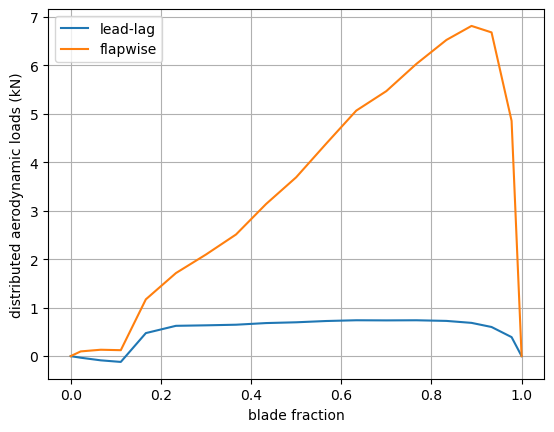

In [30]:
# plot
rstar = (r - Rhub) / (Rtip - Rhub)

# append zero at root and tip
rstar = np.concatenate([[0.0], rstar, [1.0]])
Np = np.concatenate([[0.0], Np, [0.0]])
Tp = np.concatenate([[0.0], Tp, [0.0]])


plt.plot(rstar, Tp / 1e3, label="lead-lag")
plt.plot(rstar, Np / 1e3, label="flapwise")
plt.xlabel("blade fraction")
plt.ylabel("distributed aerodynamic loads (kN)")
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [31]:
outputs, derivs = rotor.evaluate([Uinf], [Omega], [pitch])

P = outputs["P"]
T = outputs["T"]
Q = outputs["Q"]

outputs, derivs = rotor.evaluate([Uinf], [Omega], [pitch], coefficients=True)

CP = outputs["CP"]
CT = outputs["CT"]
CQ = outputs["CQ"]

print("CP =", CP)
print("CT =", CT)
print("CQ =", CQ)

CP = [0.46488091]
CT = [0.76926392]
CQ = [0.06163229]


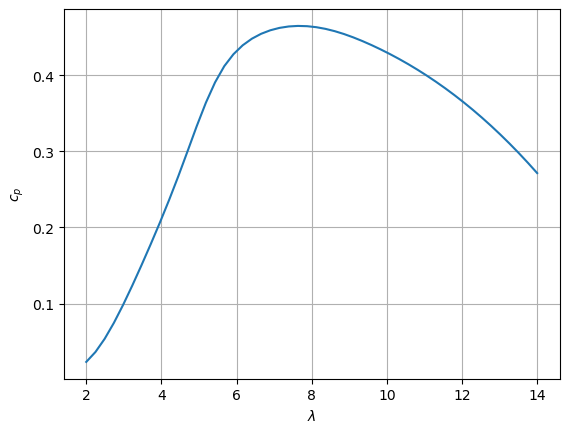

In [33]:
# velocity has a small amount of Reynolds number dependence
tsr = np.linspace(2, 14, 50)
Omega = 10.0 * np.ones_like(tsr)
Uinf = Omega * pi / 30.0 * Rtip / tsr
pitch = np.zeros_like(tsr)

outputs, derivs = rotor.evaluate(Uinf, Omega, pitch, coefficients=True)

CP = outputs["CP"]
CT = outputs["CT"]
CQ = outputs["CQ"]


plt.figure()
plt.plot(tsr, CP)
plt.xlabel("$\lambda$")
plt.ylabel("$c_p$")
plt.grid()
plt.show()